# Análisis de los grafos resultantes

## Carga de librerías necesarias

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import leidenalg as la
import random

from scipy.io import mmread
from tqdm import tqdm
from networkx.algorithms.community import modularity

## Funciones

In [2]:
def plot_graph(G):
    # --- Posicionamiento ---
    pos = nx.kamada_kawai_layout(G)
    
    # --- Preparar colores para los nodos ---
    # Usa un colormap, por ejemplo 'tab20', y asigna un color distinto a cada nodo
    cmap = plt.cm.tab20
    node_list = list(G.nodes())
    
    # --- Dibujar ---
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        node_size=100,
        edge_color='grey',          # flechas en gris
        width=1,
        with_labels=False,
        arrows=True,
        arrowsize=6
    )
    plt.show()

In [3]:
def plot_and_get_strong_component(G):
    """
    Dibuja y devuelve la mayor componente fuertemente conexa de G.
    """
    # Layout global sobre G
    pos = nx.kamada_kawai_layout(G)

    # Todas las componentes fuertes
    comps = list(nx.strongly_connected_components(G))
    print(f"Total de componentes fuertemente conexas: {len(comps)}")

    # Extraer la más grande
    Gc = G.subgraph(max(comps, key=len)).copy()
    print(f"Tamaño de la mayor componente fuerte: {Gc.number_of_nodes()} nodos")

    # Nodos de Gc
    nodes = list(Gc.nodes())

    # Dibujar
    plt.figure(figsize=(6, 5))
    nx.draw(
        Gc,
        {n: pos[n] for n in nodes},
        node_size=150,
        edge_color='grey',
        width=1,
        with_labels=False,
        arrows=True,
        arrowsize=8
    )
    plt.title("Mayor componente fuertemente conexa")
    plt.show()

    return Gc

In [4]:
def generate_random_g_no_isolates(G, num_graphs=100):
    """
    Genera `num_graphs` réplicas dirigidas con |V| y |E| iguales a G,
    garantizando que ningún nodo quede aislado y sin muestreo por rechazo.
    """
    n_nodes = G.number_of_nodes()
    m_edges = G.number_of_edges()
    nodes = list(G.nodes())
    H = []
    
    if m_edges < n_nodes - 1:
        raise ValueError(
            "No es posible evitar todos los aislados cuando m < n-1."
        )
    
    for _ in range(num_graphs):
        # 1) Barajar nodos y crear un árbol dirigido de n-1 aristas
        random.shuffle(nodes)
        H_i = nx.DiGraph()
        H_i.add_nodes_from(nodes)
        for j in range(1, n_nodes):
            u = random.choice(nodes[:j])
            v = nodes[j]
            H_i.add_edge(u, v)
        
        # 2) Añadir las aristas restantes de forma uniforme
        remaining = m_edges - (n_nodes - 1)
        # todos los pares posibles sin self‑loops ni las del árbol
        posibles = [
            (u, v)
            for u in nodes for v in nodes
            if u != v and not H_i.has_edge(u, v)
        ]
        extras = random.sample(posibles, remaining)
        H_i.add_edges_from(extras)
        
        H.append(H_i)
    
    return H

In [5]:
def _nx_to_igraph(G):
    idx = {n: i for i, n in enumerate(G.nodes())}
    g   = ig.Graph(edges=[(idx[u], idx[v]) for u, v in G.edges()],
                   directed=False)
    g.vs["name"] = list(G.nodes())
    inv = {i: n for n, i in idx.items()}
    return g, inv

def detect_leiden(G, seed=42):
    G_und = G.to_undirected()
    g_ig, inv = _nx_to_igraph(G_und)
    part = la.find_partition(g_ig, la.ModularityVertexPartition, seed=seed)
    comms = [ {inv[v] for v in cluster} for cluster in part ]
    mod = part.modularity
    return comms, mod

In [6]:
def detect_and_plot_communities(G, modularity_threshold=0.3, seed=42, verbose=True, plot=True):
    """Detecta comunidades en versión no‑dirigida de un grafo G"""
    # Convertir a no dirigido y detectar comunidades
    G_und = G.to_undirected()
    communities, mod_score = detect_leiden(G, seed=seed)

    # Calculamos qué nodos no aparecen en ninguna comunidad
    # all_found = set().union(*communities)
    # missing = set(G_und.nodes()) - all_found
    
    # Para cada nodo faltante creamos una comunidad singleton
    # y las añadimos cada una por separado
    # communities.extend([{n} for n in missing])
    
    # Calcular modularidad global
    mod_score = modularity(G_und, communities)
    status = "Alta" if mod_score > modularity_threshold else "Baja"
    if verbose:
        print(f"Modularidad global: {mod_score:.3f} → {status}")
        print(f"Se detectaron {len(communities)} comunidades:")
        for i, comm in enumerate(communities):
            print(f"  - Comunidad {i}: {len(comm)} nodos")
    else:
        return len(communities), mod_score, status

    if plot:
        # Asignar un color a cada comunidad
        cmap = plt.cm.tab20
        color_map = {}
        for i, comm in enumerate(communities):
            color = cmap(i % cmap.N)
            for node in comm:
                color_map[node] = color
    
        # Construir lista de colores en el orden de G.nodes()
        node_colors = [color_map[n] for n in G.nodes()]
    
        # 1) Construir la matriz dist:
        dist = {u: {} for u in G.nodes()}
        for u in G.nodes():
            for v in G.nodes():
                if u == v:
                    dist[u][v] = 0
                # misma comunidad → distancia baja
                elif any(u in comm and v in comm for comm in communities):
                    dist[u][v] = 1
                # distinta comunidad → distancia alta
                else:
                    dist[u][v] = 10
        
        # Posiciones
        pos = nx.kamada_kawai_layout(G, dist=dist)
    
        # Dibujar
        plt.figure(figsize=(8, 6))
        nx.draw(
            G,
            pos,
            node_size=100,
            node_color=node_colors,
            edge_color='grey',
            width=1,
            with_labels=False,
            arrows=True,
            arrowsize=6
        )
        plt.title("Comunidades")
        plt.show()

In [7]:
def graph_features(G):
    # Convertimos a no‑dirigido y extraemos componentes conexas
    G_und = G.to_undirected()
    comps = list(nx.connected_components(G_und))
    num_comps = len(comps)
    
    # Tomamos la componente gigante para los cálculos de caminos
    # Gc = G_und.subgraph(max(comps, key=len)).copy()
    
    # Parámetros básicos
    n = G_und.number_of_nodes()
    m = G_und.number_of_edges()
    
    # Cálculo del grado medio: 2*m / n
    avg_degree = (2 * m / n) if n > 0 else 0
    
    return {
        'kemeny_constant': nx.kemeny_constant(G_und),
        'transitivity': nx.transitivity(G_und),
        'avg_shortest_path': nx.average_shortest_path_length(G_und),
        'diameter': nx.diameter(G_und),
        'degree_assortativity': nx.degree_assortativity_coefficient(G_und),
        'avg_degree': avg_degree
    }

In [8]:
def calcular_aristas(n1, m1, n2, dirigido_original=False, dirigido_nuevo=False, redondear=True):
    """
    Calcula el número de aristas m2 para un grafo de n2 nodos
    de modo que conserve la misma densidad que un grafo original
    de n1 nodos y m1 aristas.

    Parámetros:
    - n1 (int): nodos del grafo original.
    - m1 (int): aristas del grafo original.
    - n2 (int): nodos del nuevo grafo.
    - dirigido_original (bool): True si el grafo original es dirigido; False si es no dirigido.
    - dirigido_nuevo (bool): True si el nuevo grafo es dirigido; False si es no dirigido.
    - redondear (bool): True para devolver un entero; False para float.

    Retorna:
    - int o float: número de aristas necesarias en el nuevo grafo.
    """
    # Determina pares posibles en el original
    if dirigido_original:
        pares1 = n1 * (n1 - 1)
    else:
        pares1 = n1 * (n1 - 1) / 2

    # Determina pares posibles en el nuevo
    if dirigido_nuevo:
        pares2 = n2 * (n2 - 1)
    else:
        pares2 = n2 * (n2 - 1) / 2

    densidad = m1 / pares1
    m2 = densidad * pares2

    return int(round(m2)) if redondear else m2

## Grafo de Retweets

In [9]:
# Carga la matriz sparse y construye el grafo dirigido
mat = mmread('../data/rt-retweet.mtx')
G_rt = nx.DiGraph(mat)

Total de componentes fuertemente conexas: 1
Tamaño de la mayor componente fuerte: 96 nodos


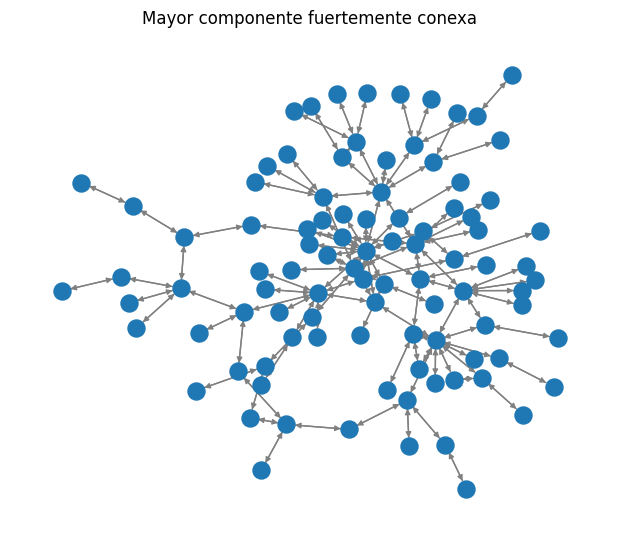

In [10]:
# 1a componente conexa
G_rt_strong = plot_and_get_strong_component(G_rt)

## Grafo generado con Exponencial y p_value_cutoff = 0.05

In [11]:
# Leer el CSV exportado
df_exp_p05 = pd.read_csv('../data/result_graph_exp_p05.csv')

In [12]:
G = nx.from_pandas_edgelist(
    df_exp_p05,
    source='origin_node',
    target='destination_node',
    edge_attr=True,
    create_using=nx.DiGraph()
)

### Visualización

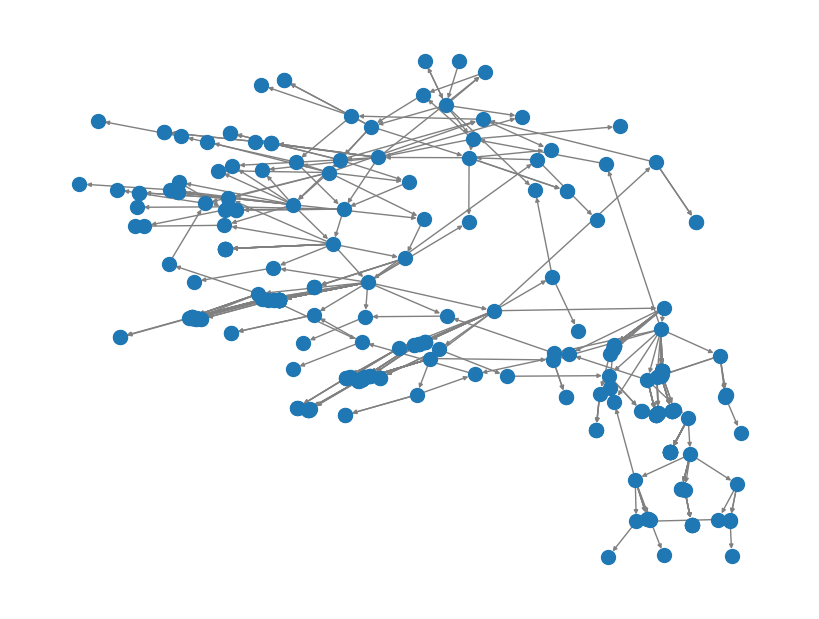

In [13]:
plot_graph(G)

Total de componentes fuertemente conexas: 265
Tamaño de la mayor componente fuerte: 24 nodos


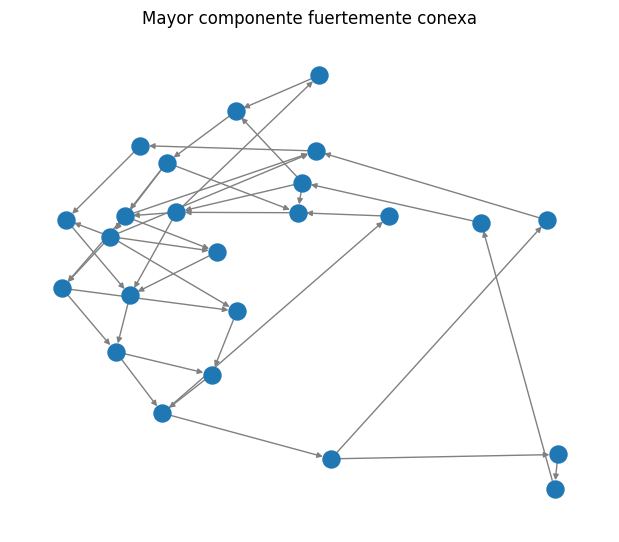

In [14]:
# 1a componente conexa
G_strong = plot_and_get_strong_component(G)

### Comparativa con grafo de Retweets

Veamos la diferencia en la densidad de ambos.

In [15]:
print(f"Densidad 1a componente conexa Netinf: {nx.density(G_strong)}")
print(f"Densidad 1a componente conexa Retweets: {nx.density(G_rt_strong)}")

Densidad 1a componente conexa Netinf: 0.07427536231884058
Densidad 1a componente conexa Retweets: 0.025657894736842105


Modularidad global: 0.680 → Alta
Se detectaron 8 comunidades:
  - Comunidad 0: 16 nodos
  - Comunidad 1: 15 nodos
  - Comunidad 2: 13 nodos
  - Comunidad 3: 12 nodos
  - Comunidad 4: 12 nodos
  - Comunidad 5: 12 nodos
  - Comunidad 6: 11 nodos
  - Comunidad 7: 5 nodos


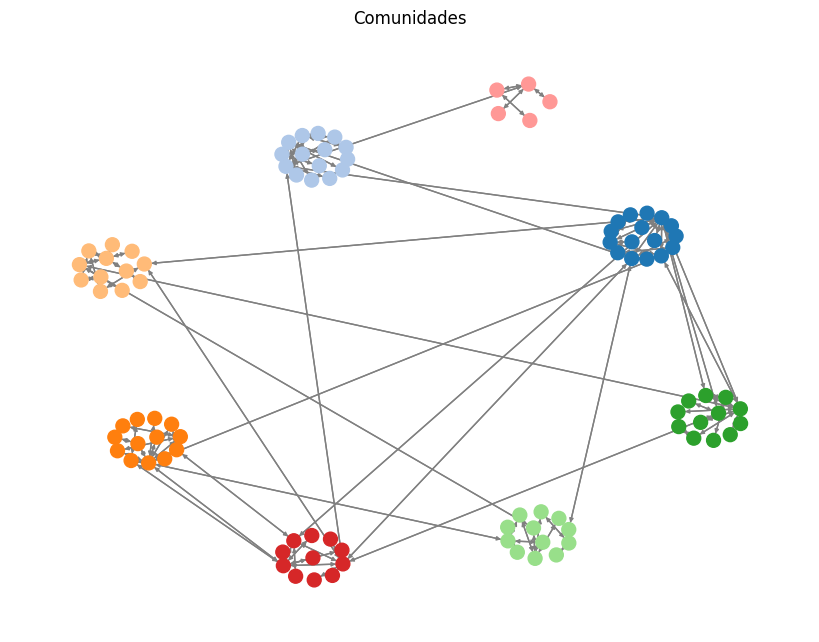

In [16]:
# Estructura de comunidades en grafo de Retweets
detect_and_plot_communities(G_rt_strong)

### Comparativa con grafos aleatorios con mismo nº de nodos y ejes

#### Estructura de comunidades

In [17]:
G_rand_list = generate_random_g_no_isolates(G)

Modularidad global: 0.793 → Alta
Se detectaron 15 comunidades:
  - Comunidad 0: 45 nodos
  - Comunidad 1: 31 nodos
  - Comunidad 2: 30 nodos
  - Comunidad 3: 27 nodos
  - Comunidad 4: 25 nodos
  - Comunidad 5: 24 nodos
  - Comunidad 6: 23 nodos
  - Comunidad 7: 19 nodos
  - Comunidad 8: 18 nodos
  - Comunidad 9: 11 nodos
  - Comunidad 10: 9 nodos
  - Comunidad 11: 7 nodos
  - Comunidad 12: 7 nodos
  - Comunidad 13: 7 nodos
  - Comunidad 14: 6 nodos


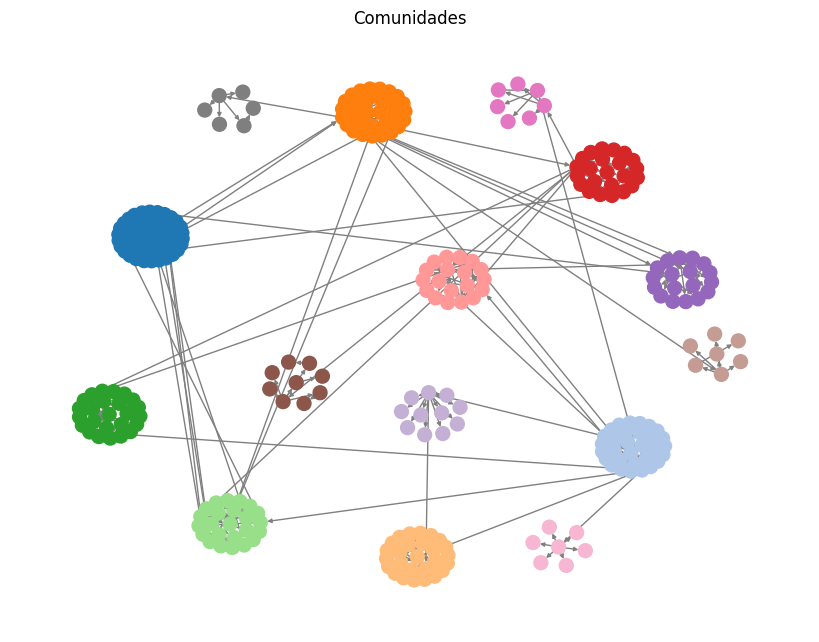

In [18]:
# Estructura de comunidades en grafo Netinf
detect_and_plot_communities(G)

In [19]:
# Estructura de comunidades en grafos aleatorios
res_list = []
for g_rand in G_rand_list:
    n_comm, mod_score, status = detect_and_plot_communities(g_rand, verbose=False, plot=False)
    res_list.append({"n_communities": n_comm, "modularity": mod_score, "status": status})

res_df = pd.DataFrame(res_list)
res_df.head()

,n_communities,modularity,status
0,18,0.776623,Alta
1,16,0.795133,Alta
2,16,0.778892,Alta
3,15,0.777859,Alta
4,16,0.781863,Alta


In [20]:
res_df.describe()

,n_communities,modularity
count,100.000000,100.000000
mean,16.310000,0.778626
std,0.939536,0.005744
min,14.000000,0.767767
25%,16.000000,0.774371
50%,16.000000,0.778560
75%,17.000000,0.781957
max,19.000000,0.796125


#### Métricas

In [21]:
feat_g = graph_features(G)

In [22]:
df_metrics = pd.DataFrame(feat_g, index=['MiRed'])
df_metrics

,kemeny_constant,transitivity,avg_shortest_path,diameter,degree_assortativity,avg_degree
MiRed,728.774313,0.021705,5.303633,13,-0.270419,2.304498


In [23]:
feat_g_rand = []
for g_rand in G_rand_list:
    feat_g_rand.append(graph_features(g_rand))

df_metrics_g_rand = pd.DataFrame(feat_g_rand)
df_metrics_g_rand.head()

,kemeny_constant,transitivity,avg_shortest_path,diameter,degree_assortativity,avg_degree
0,925.318157,0.004016,6.696367,15,-0.007577,2.311419
1,897.955384,0.008086,6.863826,16,-0.039294,2.304498
2,867.564268,0.000000,6.896122,16,-0.098332,2.304498
3,881.097853,0.004054,7.018767,16,-0.082896,2.304498
4,933.736454,0.003866,6.964437,18,-0.038292,2.311419


In [24]:
df_metrics_g_rand.describe()

,kemeny_constant,transitivity,avg_shortest_path,diameter,degree_assortativity,avg_degree
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,893.599802,0.003131,6.805659,15.19000,-0.041862,2.310104
std,29.429267,0.003415,0.209100,1.17804,0.046143,0.002729
min,804.564376,0.000000,6.375961,13.00000,-0.138703,2.304498
25%,874.192131,0.000000,6.667309,14.00000,-0.082935,2.311419
50%,894.270949,0.003786,6.814170,15.00000,-0.038489,2.311419
75%,915.146805,0.004115,6.952320,16.00000,-0.007488,2.311419
max,950.821866,0.011811,7.369858,19.00000,0.071739,2.311419


## Grafo generado con Exponencial y $n\_edges=4271$ para imitar la densidad del grafo de Retweets

In [25]:
print(f"Densidad del grafo de Retweets: {nx.density(G_rt)}")

Densidad del grafo de Retweets: 0.025657894736842105


In [26]:
print(f"Nº de nodos del grafo de Retweets: {G_rt.number_of_nodes()}")
print(f"Nº de ejes del grafo de Retweets: {G_rt.number_of_edges()}")

Nº de nodos del grafo de Retweets: 96
Nº de ejes del grafo de Retweets: 234


In [27]:
n1, m1 = G_rt.number_of_nodes(), G_rt.number_of_edges()  # grafo retweets
n2 = G.number_of_nodes()
resultado = calcular_aristas(
    n1, m1, n2,
    dirigido_original=False,
    dirigido_nuevo=True
)
print(f"Aristas para densidad igual: {resultado}")

Aristas para densidad igual: 4271


In [28]:
# Leer el CSV exportado
df_exp_nedges = pd.read_csv('../data/result_graph_nedges.csv')

In [29]:
G = nx.from_pandas_edgelist(
    df_exp_nedges,
    source='origin_node',
    target='destination_node',
    edge_attr=True,
    create_using=nx.DiGraph()
)

### Visualización

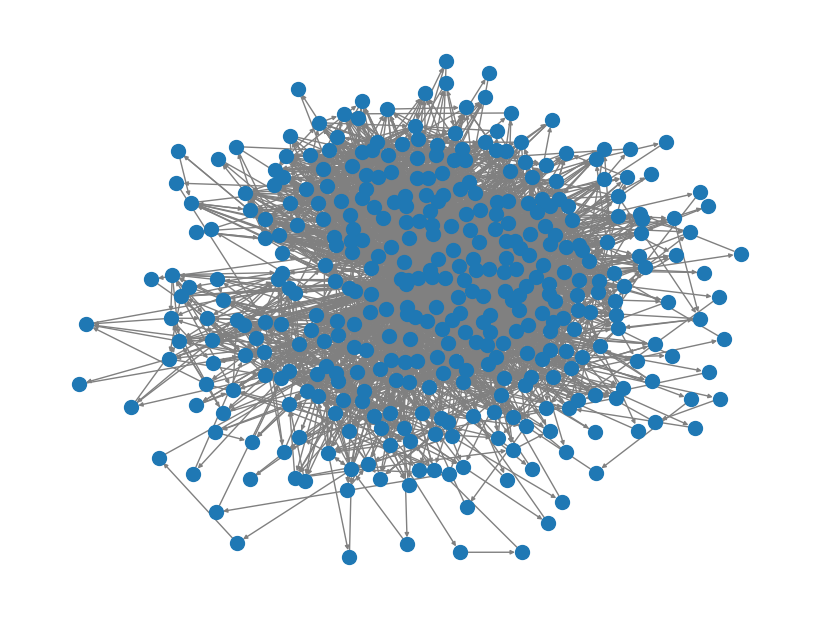

In [30]:
plot_graph(G)

Total de componentes fuertemente conexas: 4
Tamaño de la mayor componente fuerte: 378 nodos


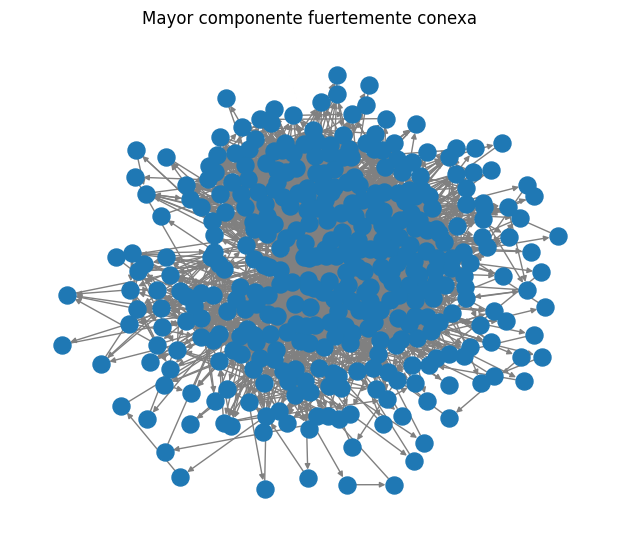

In [31]:
# 1a componente conexa
G_strong = plot_and_get_strong_component(G)

## Comparativa con grafo de Retweets

Veamos la diferencia en la densidad de ambos.

In [32]:
print(f"Densidad 1a componente conexa Netinf: {nx.density(G_strong)}")
print(f"Densidad 1a componente conexa Retweets: {nx.density(G_rt_strong)}")

Densidad 1a componente conexa Netinf: 0.02838476976408011
Densidad 1a componente conexa Retweets: 0.025657894736842105


## Comparativa con grafo aleatorio con mismo nº de nodos y ejes

#### Estructura de comunidades

In [33]:
G_rand = generate_random_g_no_isolates(G)

Modularidad global: 0.361 → Alta
Se detectaron 4 comunidades:
  - Comunidad 0: 128 nodos
  - Comunidad 1: 96 nodos
  - Comunidad 2: 86 nodos
  - Comunidad 3: 72 nodos


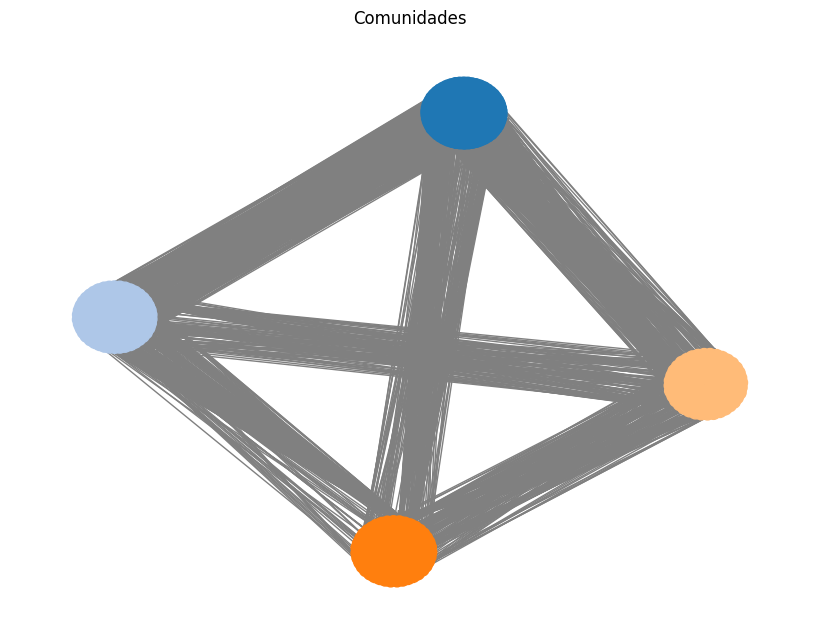

In [34]:
# Estructura de comunidades en grafo Netinf
detect_and_plot_communities(G)

#### Métricas

In [35]:
feat_g  = graph_features(G)

In [36]:
df_metrics = pd.DataFrame(feat_g, index=['MiRed'])
df_metrics

,kemeny_constant,transitivity,avg_shortest_path,diameter,degree_assortativity,avg_degree
MiRed,407.385124,0.242969,2.417034,5,-0.109706,21.136126
